## FDP inference within selected clusters

Import the necessary packages

In [1]:
import numpy as np
import numpy.matlib as npm
import matplotlib.pyplot as plt 
import sys
#sys.path.insert(0, 'C:\\Users\\12SDa\\davenpor\\davenpor\\Toolboxes\\pyrft' )
import pyrft as pr
import sanssouci as sa

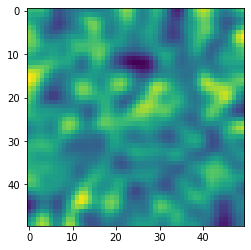

In [65]:
# Set the dimension of the example and the number of subjects
Dim = (50,50); N = 30; m = np.prod(Dim)

# Generate the category vector and obtain the corresponding design matrix
from sklearn.utils import check_random_state
rng = check_random_state(101)
categ = rng.choice(3, N, replace = True)
X = pr.groupX(categ); 

# Specify the contrast matrix (here 2 contrasts are chosen)
C = np.array([[1,-1,0],[0,1,-1]]); 

# Calulate the number contrasts
L = C.shape[0]

# Calculate the number of p-values generated (L for each voxels)
npvals = m*L

# Generate a stationary random field with given FWHM
FWHM = 4; lat_data = pr.statnoise(Dim, N, FWHM)

# Plot a sample realization of the noise
plt.imshow(lat_data.field[:,:,1])  

Calculate the t-statistics

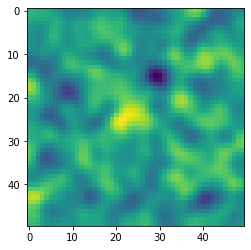

In [5]:
tstat_image, residuals = pr.contrast_tstats(lat_data, X, C)
plt.imshow(tstat_image.field[:,:,1])

In [38]:
# Specify the number of bootstraps to use
B = 100; alpha = 0.1

# Run the bootstrapped algorithm
minPperm, orig_pvalues, pivotal_stats, bs = pr.boot_contrasts(lat_data, X, C, B, 'linear', True, 1)

# Calculate the post-hoc bound
lambda_quant = np.quantile(pivotal_stats, alpha)
print('Lambda Quantile:', lambda_quant)

# Calculate the number of voxels in the mask
m = np.sum(lat_data.mask[:])

# Gives t_k^L(lambda) = lambda*k/m for k = 1, ..., m
thr = sa.t_linear(lambda_quant, np.arange(1,m+1), m)

(5000, 100)
(1, 5000)
Lambda Quantile: 0.267437500462914


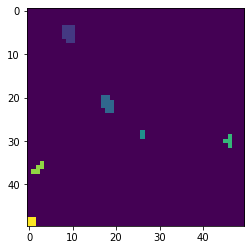

In [39]:
clusters = pr.find_clusters(orig_pvalues.field[:,:,1], CDT = 0.01, below = 1)
plt.imshow(clusters)

In [40]:
n_clusters = np.max(clusters)
for I in np.arange(n_clusters):
    voxelsincluster = np.array(clusters == (I+1), dtype = bool)
    cluster_pvalues = orig_pvalues.field[:,:,1][voxelsincluster]
    bound = sa.max_fp(cluster_pvalues, thr)
    print(bound)
    print(np.sum(voxelsincluster == 1))

11.0
11
10.0
10
2.0
2
4.0
4
5.0
5
4.0
4


## Add some spatial signal

In [66]:
signal = np.zeros(Dim)
signal[10:20,10:20] = 0.4
signal[30:35,30:35] = 0.4
w2 = np.where(categ==2)[0]

# Add the signal to the field
for I in np.arange(len(w2)):
    lat_data.field[:,:,w2[I]] = lat_data.field[:,:,w2[I]] + signal


In [67]:
# Specify the number of bootstraps to use
B = 100; alpha = 0.1

# Run the bootstrapped algorithm
minPperm, orig_pvalues, pivotal_stats, bs = pr.boot_contrasts(lat_data, X, C, B, 'linear', True, 1)

# Calculate the post-hoc bound
lambda_quant = np.quantile(pivotal_stats, alpha)
print('Lambda Quantile:', lambda_quant)

# Calculate the number of voxels in the mask
m = np.sum(lat_data.mask[:])

# Gives t_k^L(lambda) = lambda*k/m for k = 1, ..., m
thr = sa.t_linear(lambda_quant, np.arange(1,m+1), m)

(5000, 100)
(1, 5000)
Lambda Quantile: 0.1801354534931299


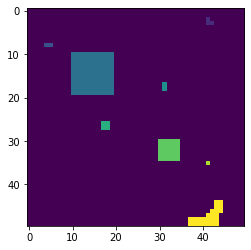

In [68]:
clusters = pr.find_clusters(orig_pvalues.field[:,:,1], CDT = 0.01, below = 1)
plt.imshow(clusters)

In [71]:
n_clusters = np.max(clusters)
for I in np.arange(n_clusters):
    voxelsincluster = np.array(clusters == (I+1), dtype = bool)
    cluster_pvalues = orig_pvalues.field[:,:,1][voxelsincluster]
    bound = len(cluster_pvalues) - sa.max_fp(cluster_pvalues, thr)
    print(bound)
    print(np.sum(voxelsincluster == 1))

0.0
3
0.0
2
89.0
100
0.0
2
0.0
4
22.0
25
0.0
1
0.0
24
